---
### Closed-Form Solution with Mass-Action Kinetics

Solve for growth rate and Y with built-in Python optimization library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a1, a2 = 23.8, 1.4
k1, k2 = 0.01, 0.003
r1 = a1/k1   # limit of Michaelis-Menten
r2 = a2/k2
N = 200

# b_min, b_max, b_large = 5e-5, 1e-3, False
b_min, b_max, b_large = 5e7, 1e8, True

b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)
#b_vals = np.linspace(b_min, b_max, N+1)

print(f"r1: {r1}, r2: {r2}")

r1: 2380.0, r2: 466.66666666666663


## Functions

In [2]:
# Softmax transformation from u1, u2 -> theta1, theta2, theta3 (LogSumExp)
from scipy.special import logsumexp
def softmax_partition(u):
    u1, u2 = u
    logZ = logsumexp([u1, 0.0, u2])
    theta1 = np.exp(u1 - logZ)
    theta2 = np.exp(-logZ)
    theta3 = np.exp(u2 - logZ)
    return theta1, theta2, theta3

# Objective function for fixed b_val using softmax
def objective_softmax(u, b_val):
    try:
        theta1, theta2, theta3 = softmax_partition(u)
        if theta1 <= 0 or theta3 <= 0:
            return np.inf
        
        term1 = (r1 * theta2) / (b_val * theta1)
        term2 = (r2 * theta3) / (b_val * theta1)
        Y1 = 1 / (1 + term1)
        Y2 = term1 / (1 + term2) * Y1
        Y3 = (r2 * theta3 / b_val) * Y2
        return -b_val * Y3  # Negative lambda (maximize lambda)
    except:
        return np.inf

def optimize_for_b_softmax(b_val, tol=1e-7, gtol=1e-8, maxiter=1000):
    if b_large:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=[0.0, 0.0],
            bounds=[(-10, 10)],
            method='L-BFGS-B',   # L-BFGS-B has bounds
            tol=tol,
            options={
                'gtol': gtol,
                'maxiter': maxiter,
                'disp': False
            }
        )
    else:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=[0.0, 0.0],
            method='Powell',
            tol=tol,                       # global tolerance
            options={
                'gtol': gtol,              # gradient tolerance
                'maxiter': maxiter,        # maximum iterations
                'disp': False               # display output: True
            }
        )
    if result.success:
        theta1, theta2, theta3 = softmax_partition(result.x)
        term1 = (r1 * theta2) / (b_val * theta1)
        term2 = (r2 * theta3) / (b_val * theta1)
        Y1 = 1 / (1 + term1)
        Y2 = term1 / (1 + term2) * Y1
        Y3 = (r2 * theta3 / b_val) * Y2
        Y4 = (r2 * theta2 * theta3) / (b_val * theta1) * Y2
        Y5 = (r2 * theta3**2) / (b_val * theta1) * Y2
        lambda_val = b_val * Y3
        r_denom = (1/(r1 * Y4)) + (1/(r2 * Y5))
        r_avg = 1 / r_denom if r_denom != 0 else np.nan
        return np.array([b_val, theta1, theta2, theta3, Y1, Y2, Y3, Y4, Y5, lambda_val, r_avg])
    return None

# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = [r for r in results if r is not None]
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

# Convert results to a 2D numpy array
results_array = np.array(results)

# Extract individual arrays (each column corresponds to a variable)
b_arr = results_array[:, 0]
theta1_arr = results_array[:, 1]
theta2_arr = results_array[:, 2]
theta3_arr = results_array[:, 3]
Y1_arr = results_array[:, 4]
Y2_arr = results_array[:, 5]
Y3_arr = results_array[:, 6]
Y4_arr = results_array[:, 7]
Y5_arr = results_array[:, 8]
lambda_arr = results_array[:, 9]
r_avg_arr = results_array[:, 10]

Optimization completed in 8.76 seconds.


## Plots

C:\Users\huang\AppData\Local\Temp\ipykernel_3912\2069801238.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


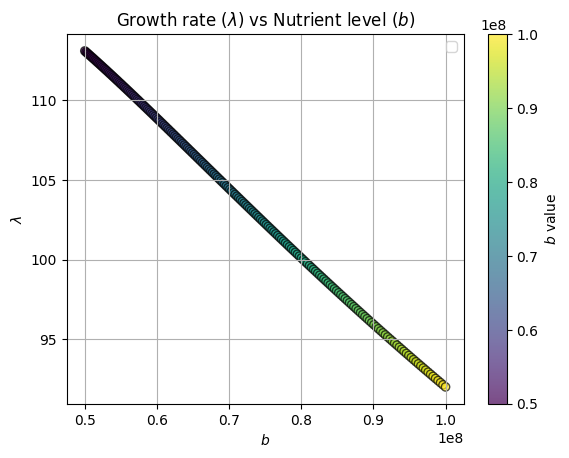

C:\Users\huang\AppData\Local\Temp\ipykernel_3912\2069801238.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


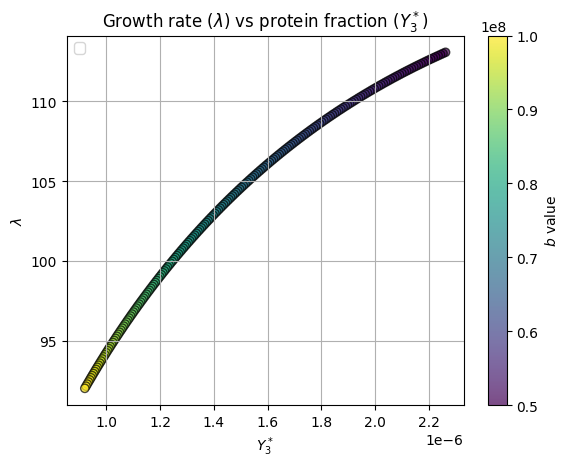

C:\Users\huang\AppData\Local\Temp\ipykernel_3912\2069801238.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


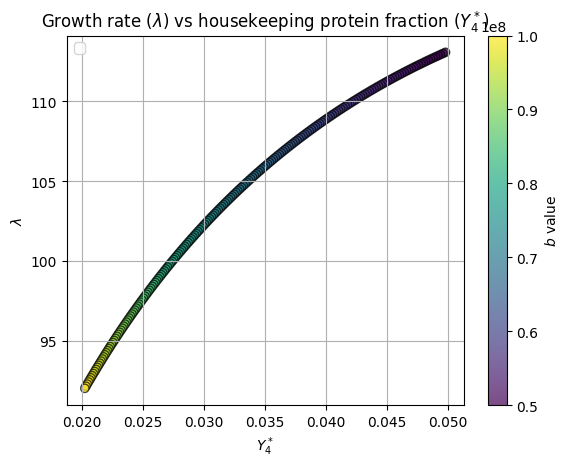

C:\Users\huang\AppData\Local\Temp\ipykernel_3912\2069801238.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


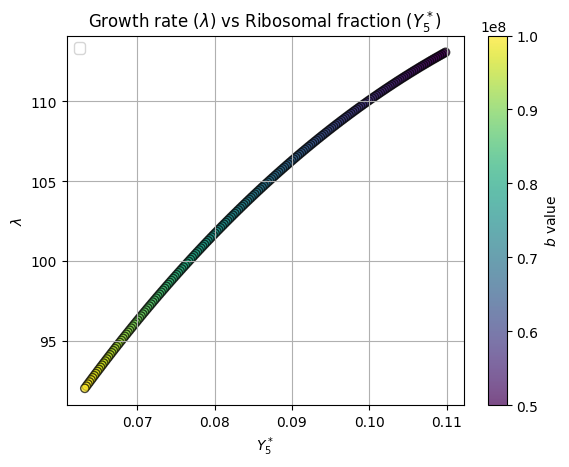

In [ ]:
# Growth rate to nutrient level (b)
plt.figure()
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend()
plt.grid(True)
plt.show()

# Growth rate to protein fraction (Y3)
plt.figure()
scatter = plt.scatter(Y3_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_3^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($Y_3^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein fraction (Y4) -> this should be constant
plt.figure()
scatter = plt.scatter(Y4_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_4^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs housekeeping protein fraction ($Y_4^*$)')
plt.grid(True)
# plt.xlim(0, 0.01)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y5)
plt.figure()
scatter = plt.scatter(Y5_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_5^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_5^*$)')
plt.grid(True)
plt.legend()
plt.show()

## Optimal Partition Strength

Data saved to PP3_MA_output.csv (200 rows)
Excel output requires openpyxl package. Install with: pip install openpyxl


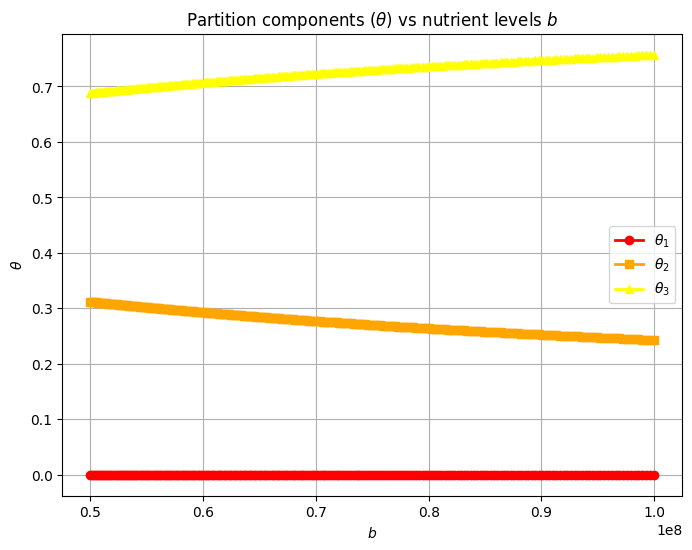

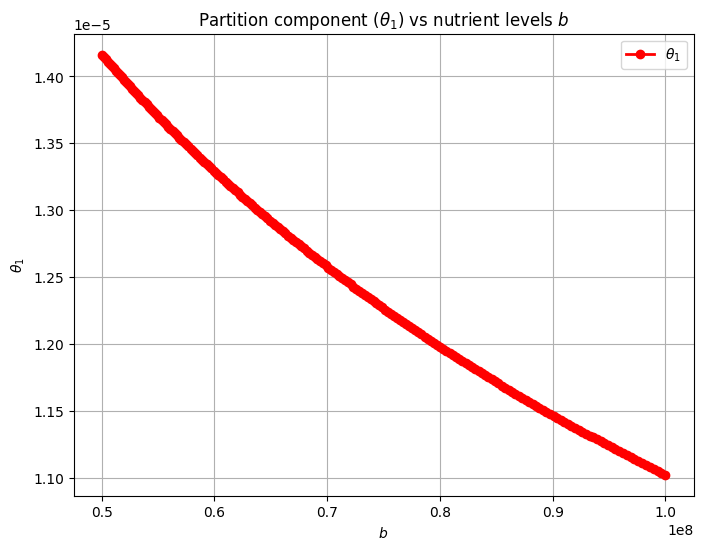

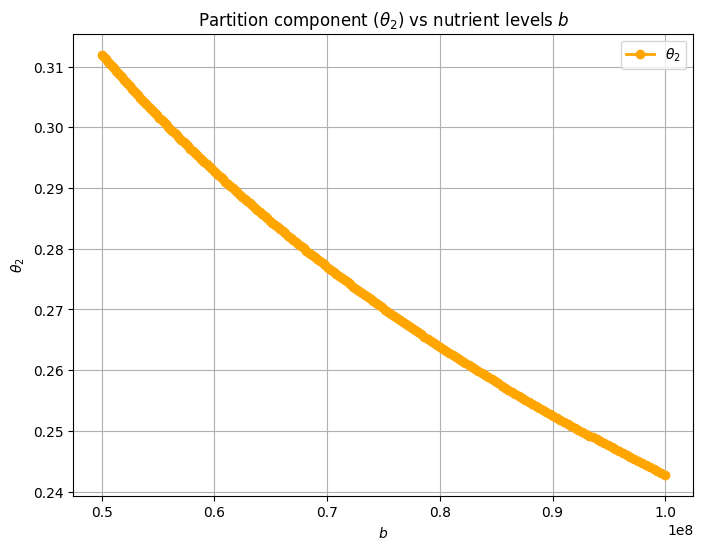

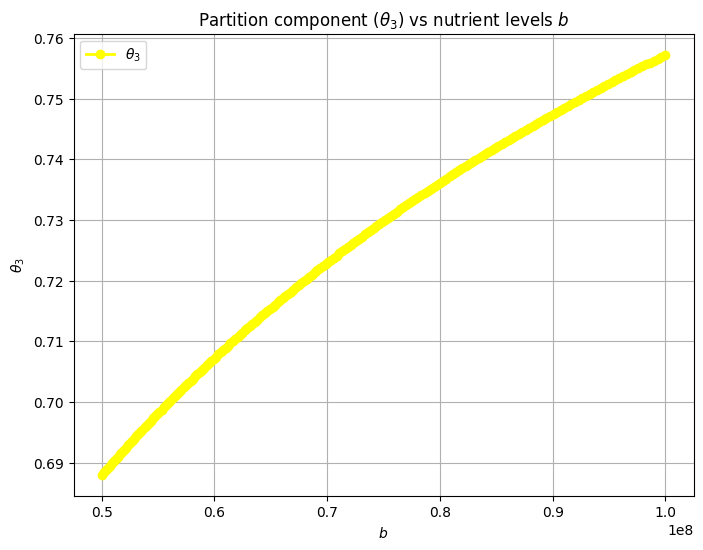

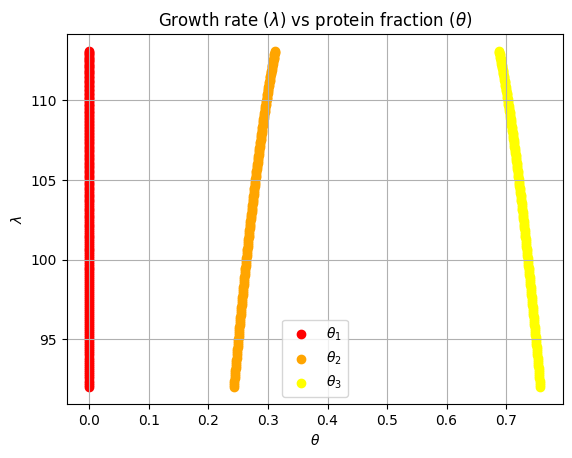

In [9]:
# Put in DataFrame and save to CSV
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    r"$Y_1": Y1_arr,
    r"$Y_2": Y2_arr,
    r"$Y_3": Y3_arr,
    r"$Y_4": Y4_arr,
    r"$Y_5": Y5_arr,
    r"$\theta_1$": theta1_arr,
    r"$\theta_2$": theta2_arr,
    r"$\theta_3$": theta3_arr,
    r"$p = \frac{\theta_2}{\theta_1}$": theta2_arr / theta1_arr,
    r"$q = \frac{\theta_3}{\theta_1}$": theta3_arr / theta1_arr,
    r"$P = \frac{p}{b}$": theta2_arr / (b_arr*theta1_arr),
    r"$Q = \frac{q}{b}$": theta3_arr / (b_arr*theta1_arr),
    r"$U = r_1 P$": (r1*theta2_arr) / (b_arr*theta1_arr),
    r"$V = r_2 Q$": (r2*theta2_arr) / (b_arr*theta1_arr)
})

# Save to CSV file
df.to_csv('PP3_MA_output.csv', index=False, float_format='%.6f')
print(f"Data saved to PP3_MA_output.csv ({len(df)} rows)")

# Also save to Excel for better formatting (optional)
try:
    df.to_excel('PP3_MA_output.xlsx', index=False, float_format='%.6f')
    print(f"Data also saved to PP3_MA_output.xlsx")
except ImportError:
    print("Excel output requires openpyxl package. Install with: pip install openpyxl")


# Partition components to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='s', color='orange')
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', marker='^', color='yellow')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta1 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_1$')
plt.title(r'Partition component ($\theta_1$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta2 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='o', color='orange')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_2$')
plt.title(r'Partition component ($\theta_2$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta3 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', marker='o', color='yellow')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_3$')
plt.title(r'Partition component ($\theta_3$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein partition \theta
plt.figure()
plt.scatter(theta1_arr, lambda_arr, label=r'$\theta_1$', c='red')
plt.scatter(theta2_arr, lambda_arr, label=r'$\theta_2$', c='orange')
plt.scatter(theta3_arr, lambda_arr, label=r'$\theta_3$', c='yellow')
plt.xlabel(r'$\theta$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($\theta$)')
plt.grid(True)
plt.legend()
plt.show()

## Time Evolution With Full ODE
The time evolution of the ODE system is studied with the `solve_ivp` python solver. This is the newer, more flexible ODE solver with better control options.

Random theta: θ₁=0.0591, θ₂=0.2517, θ₃=0.6892, sum=1.0000
Random Y0: Y0=['0.1975', '0.2352', '0.1369', '0.1712', '0.2592'], sum=1.0000


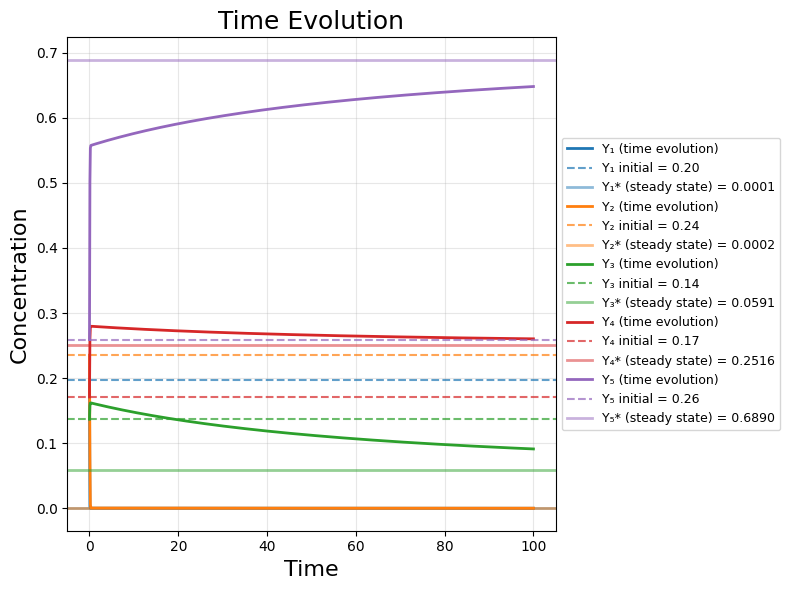

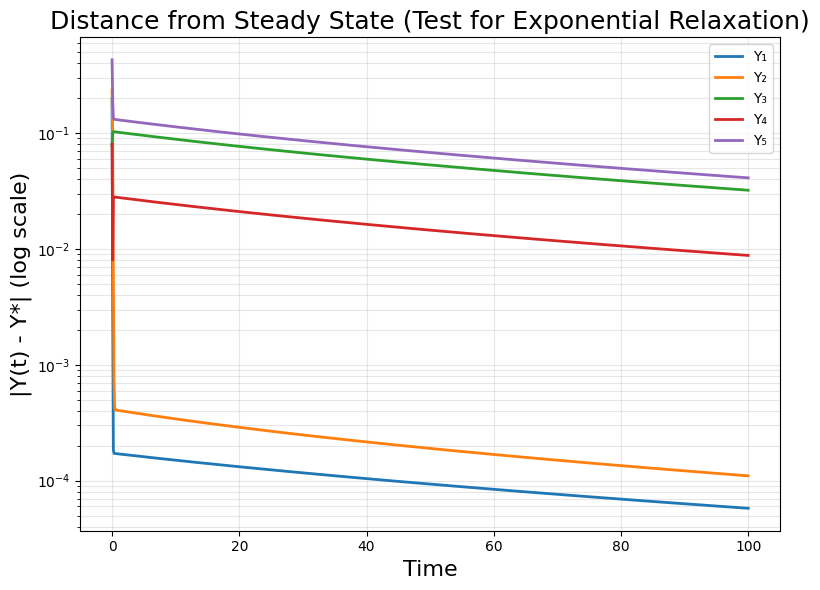

In [4]:
from scipy.integrate import solve_ivp

# Define ODE system for solve_ivp
def ode_system_ivp(t, Y, b, r1, r2, theta1, theta2, theta3):
    Y1, Y2, Y3, Y4, Y5 = Y
    dY1_dt = b*Y3 - r1*Y1*Y4 - b*Y1*Y3
    dY2_dt = r1*Y1*Y4 - r2*Y2*Y5 - b*Y2*Y3
    dY3_dt = theta1*r2*Y2*Y5 - b*Y3**2
    dY4_dt = theta2*r2*Y2*Y5 - b*Y3*Y4
    dY5_dt = theta3*r2*Y2*Y5 - b*Y3*Y5
    return [dY1_dt, dY2_dt, dY3_dt, dY4_dt, dY5_dt]

b, r1, r2 = 0.1, 200, 50

theta_raw = np.random.random(3)
theta_normalized = theta_raw / theta_raw.sum()
theta1, theta2, theta3 = theta_normalized   # random theta
Y0_raw = np.random.random(5)
Y0 = (Y0_raw / Y0_raw.sum()).tolist()   # random Y0

print(f"Random theta: θ₁={theta1:.4f}, θ₂={theta2:.4f}, θ₃={theta3:.4f}, sum={theta1+theta2+theta3:.4f}")
print(f"Random Y0: Y0={[f'{y:.4f}' for y in Y0]}, sum={sum(Y0):.4f}")

t_span = (0, 100)
t_eval = np.linspace(0, 100, 1000)
sol_rk45 = solve_ivp(
    ode_system_ivp, 
    t_span, 
    Y0, 
    args=(b, r1, r2, theta1, theta2, theta3),
    method='RK45',      # Explicit RK of order 5(4)
    t_eval=t_eval, 
    rtol=1e-11,         # Relative tolerance
    atol=1e-15,         # Absolute tolerance
    dense_output=True   # Continuous solution interpolation
)

Y1_ivp, Y2_ivp, Y3_ivp, Y4_ivp, Y5_ivp = sol_rk45.y   # Extract solutions

# Calculate steady-state values directly
term1 = (r1 * theta2) / (b * theta1)
term2 = (r2 * theta3) / (b * theta1)
Y1_ss = 1 / (1 + term1)
Y2_ss = term1 / (1 + term2) * Y1_ss
Y3_ss = (r2 * theta3 / b) * Y2_ss
Y4_ss = (r2 * theta2 * theta3) / (b * theta1) * Y2_ss
Y5_ss = (r2 * theta3**2) / (b * theta1) * Y2_ss
lambda_ss = b * Y3_ss

# Plot
fig = plt.figure(figsize=(8, 6))

Y_data = [Y1_ivp, Y2_ivp, Y3_ivp, Y4_ivp, Y5_ivp]
Y_ss_data = [Y1_ss, Y2_ss, Y3_ss, Y4_ss, Y5_ss]
labels = ['Y₁', 'Y₂', 'Y₃', 'Y₄', 'Y₅']

for i, (Y, Y_ss, label) in enumerate(zip(Y_data, Y_ss_data, labels)):
    color = f'C{i}'
    plt.plot(sol_rk45.t, Y, label=f'{label} (time evolution)', linewidth=2, color=color)
    plt.axhline(y=Y0[i], color=color, linestyle='--', linewidth=1.5, alpha=0.7, label=f'{label} initial = {Y0[i]:.2f}')
    plt.axhline(y=Y_ss, color=color, linestyle='-', linewidth=2, alpha=0.5, label=f'{label}* (steady state) = {Y_ss:.4f}')

plt.xlabel('Time', fontsize=16)
plt.ylabel('Concentration', fontsize=16)
plt.title(f'Time Evolution', fontsize=18)
plt.legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distance from steady state on log scale: log|Y(t) - Y*| vs t should be linear
fig = plt.figure(figsize=(8, 6))
decay_rates = []  # Store decay rate constants

for i, (Y, Y_ss, label) in enumerate(zip(Y_data, Y_ss_data, labels)):
    color = f'C{i}'
    distance = np.abs(Y - Y_ss)   # dist from steady state
    mask = distance > 1e-15
    if np.any(mask):
        plt.plot(sol_rk45.t[mask], distance[mask], label=f'{label}', linewidth=2, color=color)
        # line fit after t > 5
        mask_fit = (distance > 1e-15) & (sol_rk45.t > 5)
        log_distance = np.log(distance[mask_fit])
        t_fit = sol_rk45.t[mask_fit]
        coeffs = np.polyfit(t_fit, log_distance, 1)
        slope = coeffs[0]
        intercept = coeffs[1]
        
        # Calculate R² to assess quality of fit
        log_distance_fit = slope * t_fit + intercept
        residuals = log_distance - log_distance_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((log_distance - np.mean(log_distance))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        decay_rates.append({
            'Variable': label,
            'Decay_rate_k': slope,
            'R²': r_squared
        })

plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.ylabel('|Y(t) - Y*| (log scale)', fontsize=16)
plt.title('Distance from Steady State (Test for Exponential Relaxation)', fontsize=18)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()